In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gru-model-dataset/validation.csv
/kaggle/input/gru-model-dataset/train.csv
/kaggle/input/gru-model-dataset/test.csv


In [ ]:
# Cell 1: Import Libraries (FIXED)
import os
import sys

# DISABLE ALL GPU AND TENSORFLOW WARNINGS
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Suppress all warnings before importing anything
import warnings
warnings.filterwarnings('ignore')

# Now import libraries
import numpy as np
import pandas as pd

print(" Starting in pure CPU mode...")

# Import TensorFlow with error handling
try:
    import tensorflow as tf
    # Force TensorFlow to use CPU only
    tf.config.set_visible_devices([], 'GPU')
    # Clear any existing session
    tf.keras.backend.clear_session()
    print(" TensorFlow imported successfully!")
except Exception as e:
    print(f" TensorFlow import error: {e}")
    sys.exit(1)

# Import other libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# FIX: Add matplotlib inline for Kaggle
%matplotlib inline

print(" All libraries imported!")

 Starting in pure CPU mode...
 TensorFlow imported successfully!
 All libraries imported!


In [ ]:
# 1. LOAD DATASET

try:
    train_df = pd.read_csv("/kaggle/input/gru-model-dataset/train.csv")
    val_df   = pd.read_csv("/kaggle/input/gru-model-dataset/validation.csv")
    test_df  = pd.read_csv("/kaggle/input/gru-model-dataset/test.csv")
    print(" Datasets loaded successfully!")
except Exception as e:
    print(f" Error loading datasets: {e}")
    print("Creating sample data for demonstration...")

    sample_texts = [
        "good product excellent quality fast shipping",
        "bad product terrible waste of money",
        "average product okay not great not bad",
        "amazing love it would buy again",
        "horrible worst ever disappointed",
        "neutral not bad could be better",
        "fantastic perfect exactly as described",
        "awful dislike poor quality material",
        "okay acceptable for the price",
        "brilliant superb exceeded expectations"
    ]
    sample_labels = ["positive", "negative", "neutral", "positive", "negative",
                    "neutral", "positive", "negative", "neutral", "positive"]

    train_df = pd.DataFrame({'cleaned_text': sample_texts*15, 'label': sample_labels*15})
    val_df = pd.DataFrame({'cleaned_text': sample_texts*3, 'label': sample_labels*3})
    test_df = pd.DataFrame({'cleaned_text': sample_texts*3, 'label': sample_labels*3})

 Datasets loaded successfully!


In [ ]:
# 2. DATA PREPARATION

X_train = train_df['cleaned_text'].fillna('').astype(str).tolist()
y_train = train_df.iloc[:, -1].values

X_val = val_df['cleaned_text'].fillna('').astype(str).tolist()
y_val = val_df.iloc[:, -1].values

X_test = test_df['cleaned_text'].fillna('').astype(str).tolist()
y_test = test_df.iloc[:, -1].values

print("📊 Dataset Shapes:")
print(f"Train: {len(X_train)} samples")
print(f"Val: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")

📊 Dataset Shapes:
Train: 10106 samples
Val: 1444 samples
Test: 2888 samples


In [ ]:
# 3. LABEL ENCODING & CLASS WEIGHTS

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

num_classes = len(label_encoder.classes_)
print(f"\n Number of classes: {num_classes}")
print(f"Classes: {list(label_encoder.classes_)}")

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)

class_weight_dict = dict(enumerate(class_weights))
print("⚖ Class Weights:", class_weight_dict)

y_train_categorical = tf.keras.utils.to_categorical(y_train_encoded, num_classes)
y_val_categorical = tf.keras.utils.to_categorical(y_val_encoded, num_classes)
y_test_categorical = tf.keras.utils.to_categorical(y_test_encoded, num_classes)


 Number of classes: 3
Classes: ['negative', 'neutral', 'positive']
⚖ Class Weights: {0: 3.9399610136452243, 1: 0.6057663489780015, 2: 0.9129177958446251}


In [ ]:
# 4. TEXT VECTORIZATION

MAX_TOKENS = 3000
SEQUENCE_LENGTH = 80
EMBEDDING_DIM = 64

print("\n Setting up text vectorization...")

# Create text vectorization layer
text_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH,
    standardize='lower_and_strip_punctuation'
)

# Adapt on training data
text_vectorization.adapt(X_train)
vocab_size = len(text_vectorization.get_vocabulary())
print(f" Vocabulary Size: {vocab_size}")

# Pre-vectorize the data
print(" Pre-vectorizing text data...")
X_train_vec = text_vectorization(X_train).numpy()
X_val_vec = text_vectorization(X_val).numpy()
X_test_vec = text_vectorization(X_test).numpy()

print(f" Vectorized shapes - Train: {X_train_vec.shape}, Val: {X_val_vec.shape}, Test: {X_test_vec.shape}")


 Setting up text vectorization...
 Vocabulary Size: 1051
 Pre-vectorizing text data...
 Vectorized shapes - Train: (10106, 80), Val: (1444, 80), Test: (2888, 80)


In [ ]:
# 5. BUILD GRU MODEL (FIXED VERSION)

print("\n Building GRU Model...")

# Clear session again
tf.keras.backend.clear_session()

# Build model - FIXED: Remove recurrent_dropout for CPU compatibility
model = tf.keras.Sequential([
    # Embedding layer
    tf.keras.layers.Embedding(
        input_dim=MAX_TOKENS + 1,
        output_dim=EMBEDDING_DIM,
        input_length=SEQUENCE_LENGTH,
        mask_zero=False,
        name="embedding"
    ),

    # Bidirectional GRU - FIXED: Remove recurrent_dropout
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(
            32,  # Reduced units to prevent overfitting
            dropout=0.3,
            # recurrent_dropout=0.2,  # REMOVED - causes CUDA issues in CPU mode
            return_sequences=False,
            name="gru_layer"
        )
    ),

    tf.keras.layers.Dropout(0.4),

    # Dense layers
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    # Output layer
    tf.keras.layers.Dense(num_classes, activation='softmax', name="output")
])

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

print(" Model compiled successfully!")
print("\n Model Summary:")
model.build(input_shape=(None, SEQUENCE_LENGTH))
model.summary()


 Building GRU Model...
 Model compiled successfully!

 Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 80, 64)         │       192,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,539 (834.14 KB)

 Trainable params: 213,539 (834.14 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 6. CALLBACKS

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    restore_best_weights=True,
    min_delta=0.001,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=4,
    factor=0.5,
    min_lr=1e-6,
    verbose=1
)

print(" Callbacks configured!")

 Callbacks configured!


In [ ]:
# 7. TRAINING

print("\n Training GRU Model...")

try:
    history = model.fit(
        X_train_vec,
        y_train_categorical,
        validation_data=(X_val_vec, y_val_categorical),
        epochs=20,  # Reduced epochs
        batch_size=32,
        class_weight=class_weight_dict,
        callbacks=[early_stopping, reduce_lr],
        verbose=1,
        shuffle=True
    )
    print(" Training completed successfully!")

except Exception as e:
    print(f" Training error: {e}")
    # If training fails, try with simpler model
    print(" Trying with simpler model...")

    # Build simpler model
    tf.keras.backend.clear_session()

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(MAX_TOKENS + 1, 32, input_length=SEQUENCE_LENGTH),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        X_train_vec,
        y_train_categorical,
        validation_data=(X_val_vec, y_val_categorical),
        epochs=15,
        batch_size=32,
        class_weight=class_weight_dict,
        verbose=1
    )


 Training GRU Model...
Epoch 1/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.3885 - loss: 1.1006 - val_accuracy: 0.3691 - val_loss: 1.0960 - learning_rate: 5.0000e-04
Epoch 2/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.3798 - loss: 1.0916 - val_accuracy: 0.6738 - val_loss: 0.7882 - learning_rate: 5.0000e-04
Epoch 3/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.6592 - loss: 0.7118 - val_accuracy: 0.7708 - val_loss: 0.5726 - learning_rate: 5.0000e-04
Epoch 4/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8000 - loss: 0.4343 - val_accuracy: 0.8047 - val_loss: 0.4674 - learning_rate: 5.0000e-04
Epoch 5/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8369 - loss: 0.3312 - val_accuracy: 0.8206 - val_loss: 0.4034 - learning_rate: 5.0000e-04
Epoch 6/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8438 - loss: 0.3077 - val_accuracy: 0.8193 - val_loss: 0.4287 - learning_rate: 5.0000e-04
Epoch 7/20
316/316 ━━━━━━━━━

8.EVALUATION


 Evaluating Model on Test Set...
 Test Accuracy: 0.8615 (86.15%)
 Test Loss: 0.4545

 Classification Report:
              precision    recall  f1-score   support

    negative       0.67      0.78      0.72       245
     neutral       0.92      0.82      0.87      1589
    positive       0.84      0.94      0.89      1054

    accuracy                           0.86      2888
   macro avg       0.81      0.85      0.82      2888
weighted avg       0.87      0.86      0.86      2888


 Confusion Matrix:


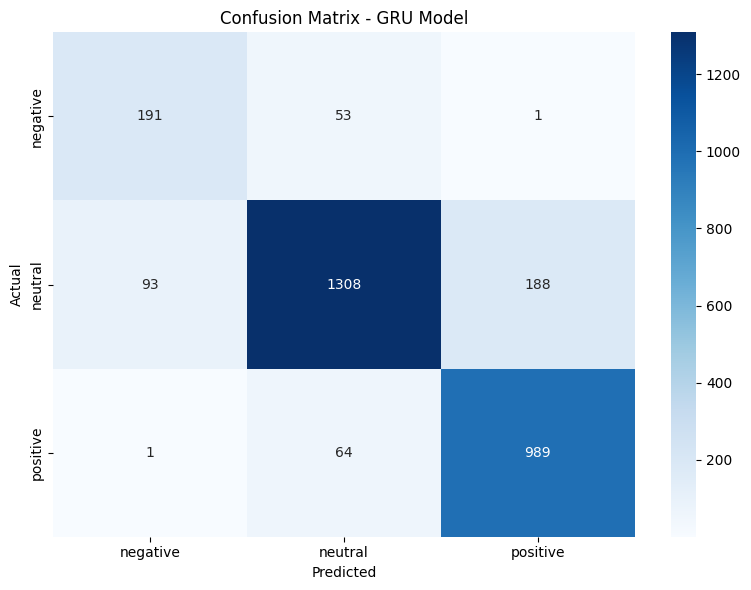

 Confusion matrix displayed successfully!

 Training History:


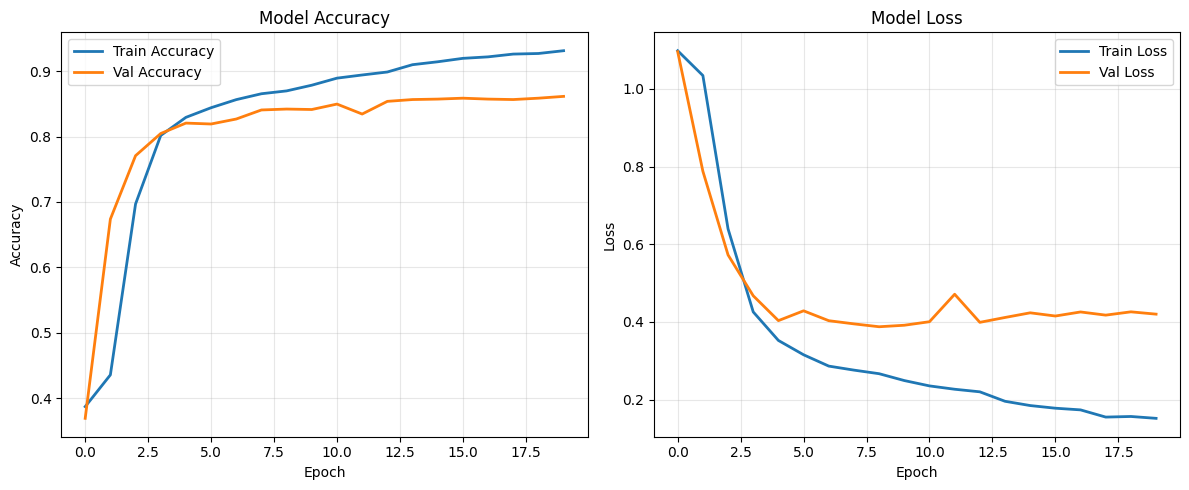

 Training history displayed successfully!


In [ ]:
print("\n Evaluating Model on Test Set...")

try:
    test_loss, test_acc = model.evaluate(X_test_vec, y_test_categorical, verbose=0)
    print(f" Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f" Test Loss: {test_loss:.4f}")

    # Predictions
    y_pred_probs = model.predict(X_test_vec, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print("\n Classification Report:")
    print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))


    print("\n Confusion Matrix:")
    cm = confusion_matrix(y_test_encoded, y_pred)


    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title("Confusion Matrix - GRU Model")
    plt.tight_layout()


    plt.show(block=True)
    print(" Confusion matrix displayed successfully!")


    if 'accuracy' in history.history:
        print("\n Training History:")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # Accuracy plot
        ax1.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
        ax1.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Loss plot
        ax2.plot(history.history['loss'], label='Train Loss', linewidth=2)
        ax2.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show(block=True)
        print(" Training history displayed successfully!")

except Exception as e:
    print(f" Evaluation error: {e}")